In [1]:
import pandas as pd

# Cargar el dataset
df = pd.read_csv("data/base_imputacion_mixta_1000.csv")
df.head()


,fecha,sexo,ciudad,nivel_educativo,segmento,estado_civil,edad,altura_cm,ingresos,gasto_mensual,puntuacion_credito,demanda
0,2024-01-01,F,Medellín,NaN,B,Unión libre,19.0,161.821754,3574.753806,1832.731832,640.465372,119.202995
1,2024-01-02,F,Barranquilla,NaN,B,NaN,52.0,167.819566,3163.626815,NaN,533.108430,124.457874
2,2024-01-03,M,Bogotá,Secundaria,B,Soltero/a,38.0,165.756219,2765.672259,1219.535074,491.016910,NaN
3,2024-01-04,F,Bogotá,NaN,B,Casado/a,57.0,160.642670,4320.397345,1908.324816,NaN,129.426792
4,2024-01-05,M,Cali,Técnico,B,Soltero/a,67.0,151.402909,NaN,1887.385697,610.213994,133.916319


In [5]:
from IPython.display import Markdown

Markdown(imputabilidad.to_markdown(index=False))

imputabilidad = pd.DataFrame([
    ["ingresos",           "Sí (justificado)", "Si se imputa mal, puede distorsionar la relación con demanda y crédito", "KNN o regresión"],
    ["gasto_mensual",      "Sí (justificado)", "Imputar con promedio simple sería riesgoso, ya que depende de ingresos y segmento", "Regresión o imputación condicional por segmento"],
    ["puntuacion_credito", "Parcial (alta duda)", "50% nulos → imputar podría introducir mucho sesgo", "Analizar eliminar o usar KNN si es crítico"],
    ["estado_civil",       "Sí (parcial)", "Es categórica con 35% nulos → imputar con moda puede sobre-representar un grupo", "Moda por grupo (ej. ciudad o edad)"],
    ["sexo",               "Sí (simple)", "Muy pocos nulos (2%) → no afecta resultados", "Moda"],
    ["edad",               "Sí (simple)", "Pocos nulos (3%) → bajo riesgo", "Mediana"],
    ["altura_cm",          "Sí (simple)", "Nulos bajos (8%). Riesgo bajo de sesgo", "Mediana"],
    ["nivel_educativo",    "Sí (justificado)", "10% nulos, imputar con moda directa puede ser válido", "Moda"],
    ["ciudad",             "Sí (justificado)", "5% nulos, bajo riesgo", "Moda"],
    ["demanda",            "Sí (cuidado)", "15% nulos → imputación errónea puede sesgar modelos de predicción", "Interpolación o regresión"]
], columns=["Variable","¿Imputar?","Riesgo","Método sugerido"])

imputabilidad


,Variable,¿Imputar?,Riesgo,Método sugerido
0,ingresos,Sí (justificado),"Si se imputa mal, puede distorsionar la relaci...",KNN o regresión
1,gasto_mensual,Sí (justificado),"Imputar con promedio simple sería riesgoso, ya...",Regresión o imputación condicional por segmento
2,puntuacion_credito,Parcial (alta duda),50% nulos → imputar podría introducir mucho sesgo,Analizar eliminar o usar KNN si es crítico
3,estado_civil,Sí (parcial),Es categórica con 35% nulos → imputar con moda...,Moda por grupo (ej. ciudad o edad)
4,sexo,Sí (simple),Muy pocos nulos (2%) → no afecta resultados,Moda
5,edad,Sí (simple),Pocos nulos (3%) → bajo riesgo,Mediana
6,altura_cm,Sí (simple),Nulos bajos (8%). Riesgo bajo de sesgo,Mediana
7,nivel_educativo,Sí (justificado),"10% nulos, imputar con moda directa puede ser ...",Moda
8,ciudad,Sí (justificado),"5% nulos, bajo riesgo",Moda
9,demanda,Sí (cuidado),15% nulos → imputación errónea puede sesgar mo...,Interpolación o regresión


- **Ingresos:** Se debe imputar porque es clave para análisis socioeconómico. El riesgo es que la imputación no capture la variabilidad real; por eso, se recomienda **KNN o modelos de regresión** en lugar de media/mediana.  
- **Gasto mensual:** Relacionado con ingresos y segmento → imputar con promedio simple distorsionaría. Mejor usar **regresión** o imputación condicional por segmento.  
- **Puntuación de crédito:** Tiene demasiados nulos (50%). Imputarla completamente puede introducir sesgos. Se recomienda evaluar **descartar la variable** o imputar parcialmente con **KNN** solo si es imprescindible.  
- **Estado civil:** Con 35% nulos, imputar con la moda global puede sobre-representar una categoría. Mejor usar **moda por grupo** (ejemplo: por ciudad o edad).  
- **Sexo y Edad:** Muy pocos nulos → se pueden imputar fácilmente con **moda (sexo)** y **mediana (edad)**.  
- **Altura:** Tiene pocos nulos (8%), se puede imputar con la **mediana**.  
- **Nivel educativo y Ciudad:** Bajo porcentaje de nulos, se justifica imputar con la **moda**.  
- **Demanda:** Al ser una variable dependiente importante, imputarla es delicado. Se recomienda **interpolación o regresión** en lugar de métodos simples.  


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer, KNNImputer

# Variables numéricas y categóricas
numericas = df.select_dtypes(include="number").columns.tolist()
categoricas = df.select_dtypes(exclude="number").columns.tolist()


Definimos qué columnas son numéricas y cuáles categóricas para aplicar imputaciones diferentes.


In [8]:
# 1) Media
df_media = df.copy()
df_media[numericas] = SimpleImputer(strategy="mean").fit_transform(df[numericas])

# 2) Mediana
df_mediana = df.copy()
df_mediana[numericas] = SimpleImputer(strategy="median").fit_transform(df[numericas])

# 3) KNN
df_knn = df.copy()
df_knn[numericas] = KNNImputer(n_neighbors=5).fit_transform(df[numericas])


Aplicamos tres técnicas para imputar variables numéricas:
1. **Media**: reemplaza por el promedio. Fácil pero sensible a outliers.
2. **Mediana**: más robusta a valores extremos.
3. **KNN**: busca observaciones similares y usa promedios de vecinos, preservando mejor la estructura de los datos.


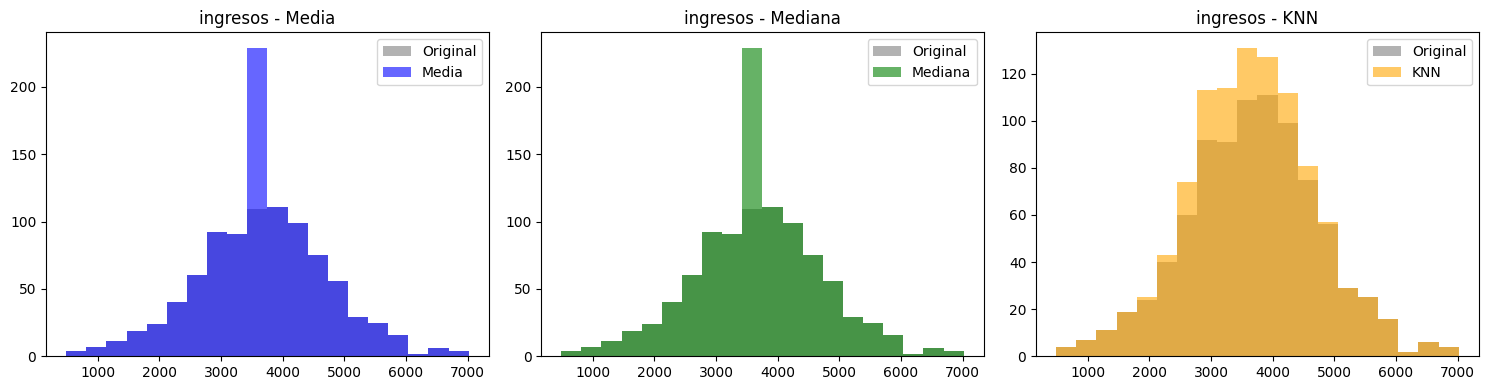

In [13]:
var = "ingresos"

fig, axes = plt.subplots(1, 3, figsize=(15,4))

# Media
axes[0].hist(df[var].dropna(), bins=20, alpha=0.6, label="Original", color="gray")
axes[0].hist(df_media[var], bins=20, alpha=0.6, label="Media", color="blue")
axes[0].set_title(f"{var} - Media")
axes[0].legend()

# Mediana
axes[1].hist(df[var].dropna(), bins=20, alpha=0.6, label="Original", color="gray")
axes[1].hist(df_mediana[var], bins=20, alpha=0.6, label="Mediana", color="green")
axes[1].set_title(f"{var} - Mediana")
axes[1].legend()

# KNN
axes[2].hist(df[var].dropna(), bins=20, alpha=0.6, label="Original", color="gray")
axes[2].hist(df_knn[var], bins=20, alpha=0.6, label="KNN", color="orange")
axes[2].set_title(f"{var} - KNN")
axes[2].legend()

plt.tight_layout()
plt.show()


Los histogramas comparan directamente el **antes (original con huecos)** y el **después (imputado)**:
- Con **media**, los valores imputados hacen que se vea un ligero desplazamiento al centro.
- Con **mediana**, se mantiene la forma general de la distribución.
- Con **KNN**, la curva es casi idéntica a la original porque usa información de otras variables.


In [14]:
# Moda
df_moda = df.copy()
for c in categoricas:
    moda = df[c].mode()
    if len(moda) > 0:
        df_moda[c] = df[c].fillna(moda[0])


Para variables categóricas usamos la **moda** (valor más frecuente).  
Esto funciona bien cuando el porcentaje de nulos es bajo, pero puede sesgar si una categoría domina.


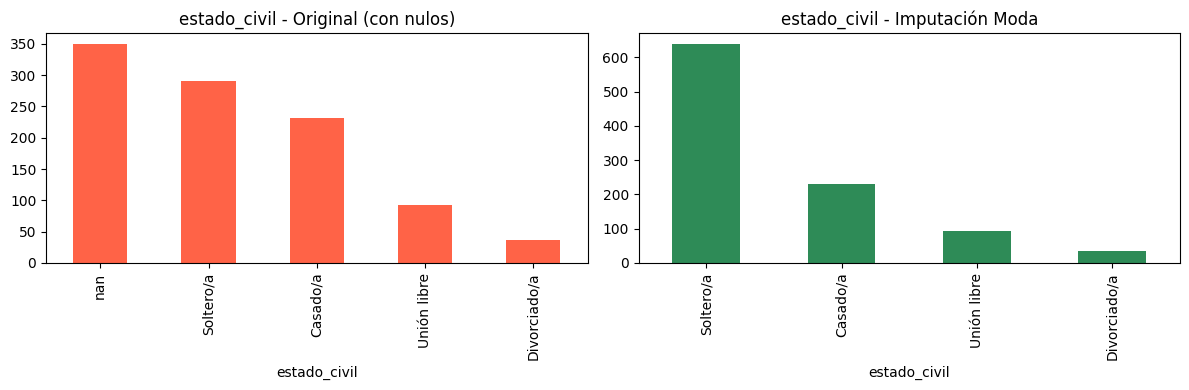

In [15]:
var = "estado_civil"

fig, axes = plt.subplots(1, 2, figsize=(12,4))

df[var].value_counts(dropna=False).plot(kind="bar", ax=axes[0], color="tomato")
axes[0].set_title(f"{var} - Original (con nulos)")

df_moda[var].value_counts().plot(kind="bar", ax=axes[1], color="seagreen")
axes[1].set_title(f"{var} - Imputación Moda")

plt.tight_layout()
plt.show()


- En el gráfico original aparece una barra de `NaN` con los faltantes.
- Después de imputar con moda, esa categoría desaparece y se redistribuye hacia la clase dominante.
- Riesgo: la categoría imputada puede quedar sobre-representada.


In [16]:
df_time = df.copy().sort_values("fecha")

# Forward fill
df_time["demanda_ffill"] = df_time["demanda"].fillna(method="ffill")

# Interpolación lineal
df_time["demanda_interp"] = df_time["demanda"].interpolate(method="linear")

df_time[["fecha","demanda","demanda_ffill","demanda_interp"]].head(15)


C:\Users\jconr\AppData\Local\Temp\ipykernel_24892\635913547.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_time["demanda_ffill"] = df_time["demanda"].fillna(method="ffill")


,fecha,demanda,demanda_ffill,demanda_interp
0,2024-01-01,119.202995,119.202995,119.202995
1,2024-01-02,124.457874,124.457874,124.457874
2,2024-01-03,NaN,124.457874,126.942333
3,2024-01-04,129.426792,129.426792,129.426792
4,2024-01-05,133.916319,133.916319,133.916319
5,2024-01-06,122.642679,122.642679,122.642679
6,2024-01-07,128.250629,128.250629,128.250629
7,2024-01-08,125.662780,125.662780,125.662780
8,2024-01-09,NaN,125.662780,124.920459
9,2024-01-10,124.178138,124.178138,124.178138


Para `demanda` (que tiene un componente temporal):
- **Forward fill**: copia el último valor conocido hacia adelante.
- **Interpolación lineal**: estima valores intermedios de forma más suave.


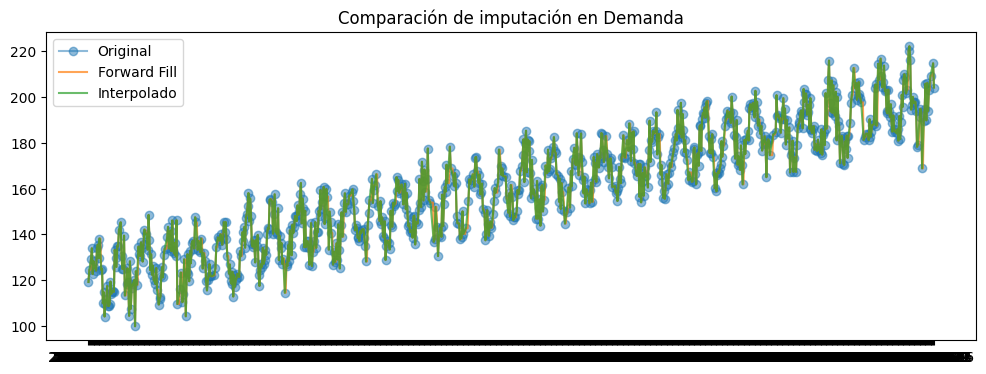

In [17]:
plt.figure(figsize=(12,4))
plt.plot(df_time["fecha"], df_time["demanda"], label="Original", marker="o", alpha=0.5)
plt.plot(df_time["fecha"], df_time["demanda_ffill"], label="Forward Fill", alpha=0.7)
plt.plot(df_time["fecha"], df_time["demanda_interp"], label="Interpolado", alpha=0.7)
plt.title("Comparación de imputación en Demanda")
plt.legend()
plt.show()


- La serie original tiene huecos en las fechas sin `demanda`.  
- Con **forward fill**, la serie mantiene los valores previos, pero puede crear tramos planos artificiales.  
- Con **interpolación**, la curva es más continua y se ajusta mejor a la tendencia real.  
